## Greedy search #2

{'Pearlescent Blue': {'rgb': [0.3137254901960784, 0.5058823529411764, 0.6901960784313725], 'alpha': np.float64(0.04998931898973191)}, 'Perfect Orange': {'rgb': [0.9490196078431372, 0.45098039215686275, 0.19215686274509805], 'alpha': np.float64(0.06449301496838222)}, 'Gun Metal Gray': {'rgb': [0.30980392156862746, 0.33725490196078434, 0.35294117647058826], 'alpha': np.float64(0.24852270692471412)}, 'Turquoise': {'rgb': [0.06274509803921569, 0.6, 0.5803921568627451], 'alpha': np.float64(0.18126924692201818)}, 'Hi-Flow Light Gray': {'rgb': [0.6470588235294118, 0.6509803921568628, 0.6392156862745098], 'alpha': np.float64(0.3296799539643607)}, 'Amethyst Violet': {'rgb': [0.5882352941176471, 0.27058823529411763, 0.48627450980392156], 'alpha': np.float64(0.004301068623984494)}}
Pearlescent Blue 0
62.7103160064023 -0.27529939532272074 47.11023550372709
Perfect Orange 0
95.42138561090349 -0.2387948642260843 47.73959038314413
Gun Metal Gray 0
53.84721632178211 -0.13529279423420915 48.03219719608

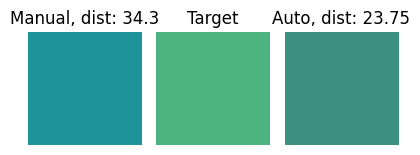

['Pearlescent Blue', 'Pearlescent Blue', 'Pearlescent Blue', 'Turquoise', 'Turquoise']


C:\Users\Matyanson\AppData\Local\Temp\ipykernel_18144\1527654396.py:141: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle(


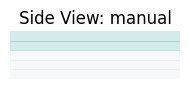

['Amethyst Violet', 'Amethyst Violet', 'Amethyst Violet', 'Amethyst Violet', 'Amethyst Violet', 'Amethyst Violet', 'Amethyst Violet', 'Amethyst Violet', 'Amethyst Violet', 'Perfect Orange', 'Perfect Orange', 'Perfect Orange', 'Perfect Orange', 'Perfect Orange', 'Turquoise', 'Turquoise', 'Turquoise', 'Turquoise']


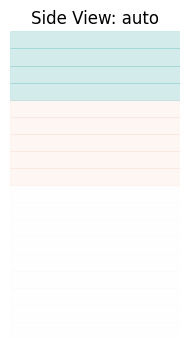

In [ ]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt

# --- UTILITY FUNCTIONS ---
def clamp(lb, ub, val):
    return min(max(lb, val), ub)

def rgb_to_lab(rgb):
    rgb = np.array(rgb).reshape(1, 1, 3)
    lab = color.rgb2lab(rgb)
    return lab[0, 0]

def lab_to_rgb(lab):
    lab = np.array(lab).reshape(1, 1, 3)
    rgb = color.lab2rgb(lab)
    return rgb[0, 0]

def alpha_from_td(thickness, td):
    """
    Convert thickness (mm) and transmission distance (mm) to an opacity:
      alpha = 1 - exp(-thickness / td)
    """
    return 1 - np.exp(-thickness / td)

def composite_over(base_rgb, top_rgb, top_alpha):
    base_rgb = np.array(base_rgb, dtype=np.float64)
    top_rgb = np.array(top_rgb, dtype=np.float64)

    return top_alpha * top_rgb + (1 - top_alpha) * base_rgb

def color_distance(rgb1, rgb2):
    rgb1 = np.array(rgb1).reshape(1, 1, 3)
    rgb2 = np.array(rgb2).reshape(1, 1, 3)
    lab1 = color.rgb2lab(rgb1)
    lab2 = color.rgb2lab(rgb2)

    # Euclidean distance in LAB space
    return np.linalg.norm(lab1 - lab2)


# --- GLOBAL ---
filaments = {
    'Pearlescent Blue': {
        'rgb': [0.3137254901960784, 0.5058823529411764, 0.6901960784313725],
        'td': 3.9,   # Transmission Distance in mm
    },
    'Perfect Orange': {
        'rgb': [0.9490196078431372, 0.45098039215686275, 0.19215686274509805],
        'td': 3.0,
    },
    'Gun Metal Gray': {
        'rgb': [0.30980392156862746, 0.33725490196078434, 0.35294117647058826],
        'td': 0.7,
    },
    'Turquoise': {
        'rgb': [0.06274509803921569, 0.6, 0.5803921568627451],
        'td': 1.0,
    },
    'Hi-Flow Light Gray': {
        'rgb': [0.6470588235294118, 0.6509803921568628, 0.6392156862745098],
        'td': 0.5,
    },
    'Amethyst Violet': {
        'rgb': [0.5882352941176471, 0.27058823529411763, 0.48627450980392156],
        'td': 46.4,
    },
}

layer_thickness = 0.2  # mm per layer
base_color = [0.0, 0.0, 0.0] # [0.5, 0.5, 0.5]  # white background
target_color = [0.0, 0.5, 0.5]  # custom teal
target_color = [0.3, 0.7, 0.5]

# --- SETUP ---
colors = {} # {"rgb", "alpha"}
for f_name, f in filaments.items():
    rgb = f['rgb']
    td = f['td']
    alpha = alpha_from_td(layer_thickness, td)
    colors[f_name] = {
        "rgb": rgb,
        "alpha": alpha
    }

print(colors)

# 6) Blend layer by layer using TD-based alpha
def blend_layers(layers):
    current_rgb = np.array(base_color, dtype=float)
    for i, name in enumerate(layers, start=1):
        rgb = np.array(colors[name]['rgb'], dtype=float)
        alpha = colors[name]['alpha']
        current_rgb = composite_over(current_rgb, rgb, alpha)

    return current_rgb


def blend_layers_alpha(layers):
    current_rgb = np.array([0.0, 0.0, 0.0], dtype=float)
    current_alpha = 0.0

    for name in layers:
        rgb = np.array(colors[name]['rgb'], dtype=float)
        alpha = float(colors[name]['alpha'])

        current_rgb = rgb * alpha + current_rgb * (1 - alpha)
        current_alpha = alpha + current_alpha * (1 - alpha)
    
    return [current_rgb / current_alpha, current_alpha]

# 7) Show a side-by-side comparison of blended vs. target
def print_comparasion(rgb1, rgb2):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4, 2))
    dist1 = round(color_distance(rgb1, target_color), 2)
    ax1.imshow(np.ones((10,10,3)) * rgb1.reshape((1,1,3)))
    ax1.set_title(f"Manual, dist: {dist1}")

    ax2.imshow(np.ones((10,10,3)) * np.array(target_color).reshape((1,1,3)))
    ax2.set_title("Target")
    
    dist2 = round(color_distance(rgb2, target_color), 2)
    ax3.imshow(np.ones((10,10,3)) * rgb2.reshape((1,1,3)))
    ax3.set_title(f"Auto, dist: {dist2}")

    for ax in (ax1, ax2, ax3):
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 8) Visualize each layer from the side with uniform thickness
def visualize_stack(stack, title):
    print(stack)
    total_thickness = layer_thickness * len(stack)
    fig2, ax2 = plt.subplots(figsize=(2, total_thickness))
    y_bottom = 0
    for i, name in enumerate(stack, start=1):
        rgb = colors[name]['rgb']
        alpha = colors[name]['alpha']
        rect = plt.Rectangle(
            (0, y_bottom), 1, layer_thickness,
            color=(rgb[0], rgb[1], rgb[2], alpha),
            edgecolor='black',
            linewidth=0.5
        )
        ax2.add_patch(rect)
        y_bottom += layer_thickness

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, total_thickness)
    ax2.set_aspect('auto')
    ax2.axis('off')
    ax2.set_title(title)

    plt.tight_layout()
    plt.show()


# thickness in number of layers
def max_color_thickness(c_name, stack):
    stack = list(stack) + [c_name]

    color_dist, closest_dist, center_dist = get_stack_potential(stack)

    i = 0
    while(closest_dist == 0 and i < 50):
        stack.append(c_name)
        color_dist, closest_dist, center_dist = get_stack_potential(stack)
        i += 1
    
    return i


def get_stack(max_layers):
    curr_stack = []

    for i in range(max_layers):
        best_color_dist = 10000
        best_stack = None

        for c_name, c in colors.items():

            # if is already present, add at the same index
            stack_copy = list(curr_stack)

            if c_name in curr_stack:
                color_index = curr_stack.index(c_name)
                stack_copy.insert(color_index, c_name)
            else:
                stack_copy.insert(0, c_name)
            
            
            max_thickness = max_color_thickness(c_name, stack_copy)
            print(c_name, max_thickness)

            color_dist, closest_dist, center_dist = get_stack_potential(stack_copy)
            blended = blend_layers(stack_copy)
            dist = color_distance(blended, target_color)
            print(color_dist, closest_dist, center_dist)

            compare_dist = color_dist

            if(closest_dist <= 0 and compare_dist < best_color_dist):
                best_color_dist = compare_dist
                best_stack = stack_copy
            
        if(best_stack):
            curr_stack = best_stack
            print("best color: ", best_stack)
        else: break

    
    return curr_stack
            
            
    


def get_stack_potential(stack):

    rgb, alpha = blend_layers_alpha(stack)

    min_color = composite_over([0.0, 0.0, 0.0], rgb, alpha)
    max_color = composite_over([1.0, 1.0, 1.0], rgb, alpha)

    center_color = [
        (min_color[0] + max_color[0]) * 0.5,
        (min_color[1] + max_color[1]) * 0.5,
        (min_color[2] + max_color[2]) * 0.5,
    ]


    center_dist = color_distance(center_color, target_color)

    color_dist = color_distance(rgb, target_color)

    closest_color = [
        clamp(min_color[0], max_color[0], target_color[0]),
        clamp(min_color[1], max_color[1], target_color[1]),
        clamp(min_color[2], max_color[2], target_color[2]),
    ]
    closest_dist = color_distance(closest_color, target_color)

    # if target color is inside the prism, return - distance to the closest wall
    if(closest_dist == 0.0):
        closest_dist = - min(
            target_color[0] - min_color[0], target_color[1] - min_color[1], target_color[2] - min_color[2],
            max_color[0] - target_color[0], max_color[1] - target_color[1], max_color[2] - target_color[2],
        )

    

    return [color_dist, closest_dist, center_dist]








# --- DO STUFF ---



stack_manual = ['Pearlescent Blue'] * 3 + ['Turquoise'] * 2
stack_auto = get_stack(100)

blended_manual, alpha = blend_layers_alpha(stack_manual)
blended_auto_rgb, alpha = blend_layers_alpha(stack_auto)
print(len(stack_auto))

print_comparasion(blended_manual, blended_auto_rgb)

visualize_stack(stack_manual, "Side View: manual")
visualize_stack(stack_auto, "Side View: auto")